In [71]:
import pandas as pd
import matplotlib.pyplot as plt
import itertools
%matplotlib inline

## Introduction

In this notebook, we explore how 6 genes are distributed in different types of cells. Most of the genes can't co-exist in one type of cell. The data file path is hard coded.


In [1]:
genes = {
"RBFOX3":"ENSG00000167281", 
"MOBP":"ENSG00000168314", 
"DOCK8":"ENSG00000107099", 
"FLT1":"ENSG00000102755", 
"VCAN":"ENSG00000038427", 
"SLC1A2":"ENSG00000110436" 
}

In [9]:
#extract the 6 gene informations from the FA14X datasets to variable "result"
filename = "/project/hackathon/hackers05/shared/FA14XrawNorma.csv"
fin = open(filename)
enids = set(genes.keys())
result = []
count = 0
row_number = 0
while True:
    line = fin.readline()
    row_number += 1
    if row_number % 1000 == 0:
        print(row_number)
#     if row_number == 20:
#         break
#     print(line[:18])
    if not line:
        break
    if (line[:4] in enids) or (line[:5] in enids) or (line[:6] in enids):
        print(line[:15])
        result.append(line)
        count += 1
fin.close()    

1000
2000
3000
4000
MOBP,-0.1582817
5000
6000
7000
VCAN,-0.1480279
VCAN-AS1,-0.011
8000
9000
10000
11000
12000
DOCK8,-0.153295
13000
14000
15000
SLC1A2,2.682485
16000
17000
18000
FLT1,-0.0374967
19000
20000
21000
22000
RBFOX3,-0.21894
23000
24000
25000
26000


In [18]:
#split the result and build a DataFrame "df"
result_clear = [gene.strip().split(',') for gene in result]

df = pd.DataFrame(result_clear)

df.iloc[0, 0]

df = df.infer_objects()

df.set_index(0, inplace=True)

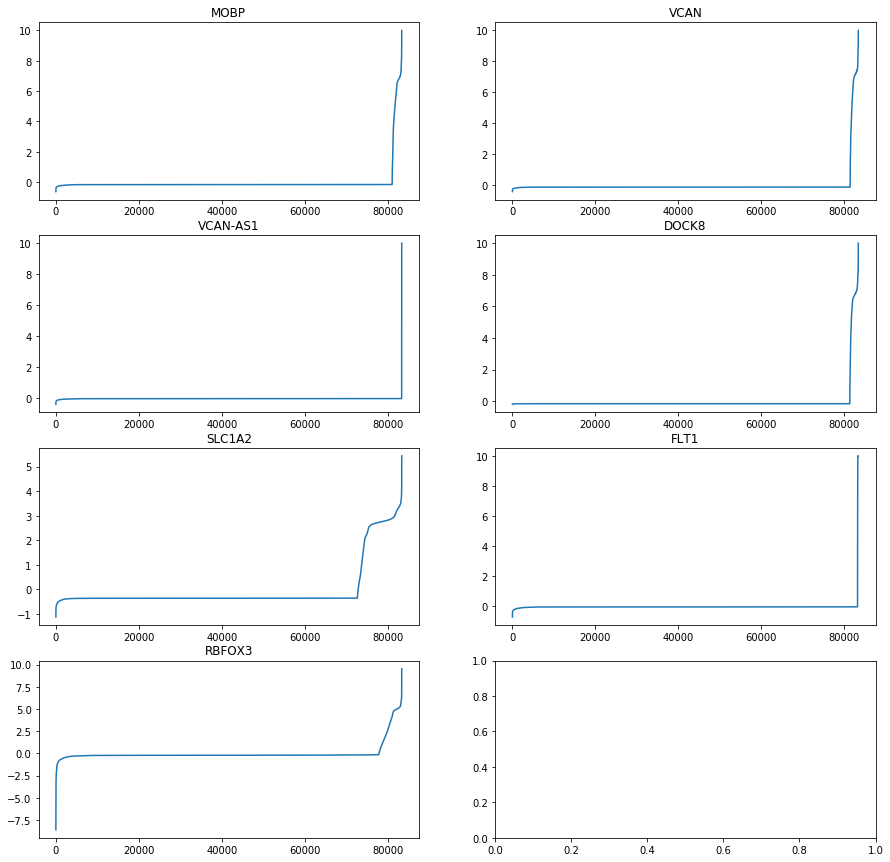

In [68]:
#Draw the graph of each gene's quantity in different cells
df.iloc[0,:].sort_values().reset_index(drop=True)
fig, axes = plt.subplots(nrows=4, ncols=2)
fig
row_count = 0
column_count = 0
for i in range(7):
    
    df.iloc[i,:].sort_values().reset_index(drop=True).plot(ax=axes[row_count, column_count], figsize=(15,15), title=df.index[i])
    if column_count == 0:
        column_count = 1
    elif column_count == 1:
        column_count = 0
        row_count += 1

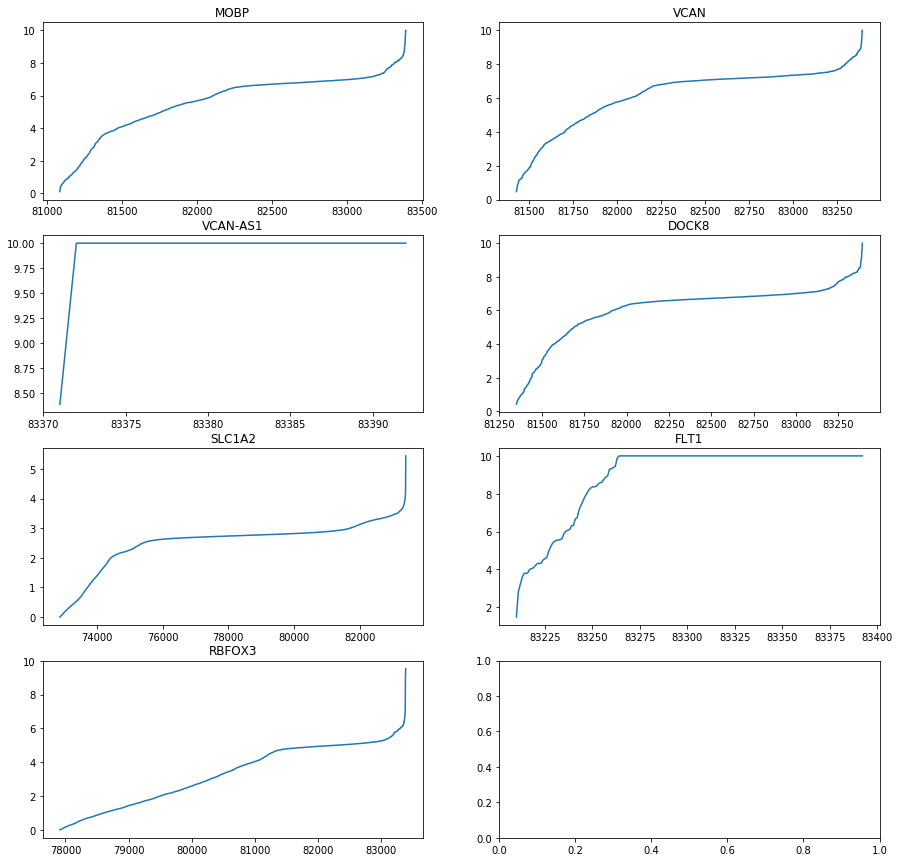

In [69]:
#Draw the graph of each gene's quantity in cells if the gene's quantity is larger than zero.

df.iloc[0,:].sort_values().reset_index(drop=True)
fig, axes = plt.subplots(nrows=4, ncols=2)
fig
row_count = 0
column_count = 0
for i in range(7):
    gene_s = df.iloc[i,:].sort_values().reset_index(drop=True)
    gene_s[gene_s>0].plot(ax=axes[row_count, column_count], figsize=(15,15), title=df.index[i])
    if column_count == 0:
        column_count = 1
    elif column_count == 1:
        column_count = 0
        row_count += 1

In [73]:
#generate a boolean matrix to exhaust all the co-exist of the 6 genes in one cell
judge_funcs = [True, False]
#three_judges = list(map(list, itertools.product(judge_funcs, repeat=3)))      
#three_judges
six_judges = list(map(list, itertools.product(judge_funcs, repeat=6)))
six_judges[:3]

[[True, True, True, True, True, True],
 [True, True, True, True, True, False],
 [True, True, True, True, False, True]]

In [98]:
# important function to compute the total number for each co-exist pattern in cells
def detect6(thhold):
    columns = list(genes.keys())
    columns.append("result")
    result = pd.DataFrame(columns=columns)
    special_df = df.loc[list(genes.keys()), :]
    print(special_df.shape)
    for judge_row in six_judges:
        logic_matrix = (special_df >= thold).eq(judge_row, axis=0)
        row = judge_row.copy()
        row.append(logic_matrix.all(axis=0).sum(axis=0))
        result.loc[len(result),:] = row            
    return result

In [99]:
result = detect6(2)

(6, 83393)


In [83]:
result.tail()

,RBFOX3,MOBP,DOCK8,FLT1,VCAN,SLC1A2,result
59,False,False,False,True,False,False,160
60,False,False,False,False,True,True,0
61,False,False,False,False,True,False,1578
62,False,False,False,False,False,True,18
63,False,False,False,False,False,False,75595


In [130]:
#replace the boolean value True to >= 2 and False to < 2
result2[list(genes.keys())] = result2[list(genes.keys())].replace(to_replace=True, value=">=2").replace(to_replace=False, value="<2")

In [132]:
result2.to_csv("/project/hackathon/hackers05/shared/yjxu_gene_count_summary_FA14X.csv")

In [145]:
# function to assign a cell type to each cell based on their 6 genes quantities.
def choose_cell_type(col):
    number_of_true = col.sum(axis=0)
    if number_of_true == 0:
        return "ambient"
    elif number_of_true > 1.0:
        return "mix-debris"
    else:
        if col[0]:
            return "neuron"
        elif col[1]:
            return "oligo"
        elif col[2]:
            return "micro"
        elif col[3]:
            return "endo"
        elif col[4]:
            return "opc"
        elif col[5]:
            return "astro"
        


In [146]:
#execute the function above
(df.loc[list(genes.keys()), :]>=2.0).apply(choose_cell_type, axis=0)

1             astro
2           ambient
3           ambient
4           ambient
5           ambient
6           ambient
7            neuron
8             astro
9           ambient
10          ambient
11            micro
12          ambient
13          ambient
14          ambient
15           neuron
16            astro
17          ambient
18       mix-debris
19          ambient
20          ambient
21           neuron
22       mix-debris
23          ambient
24          ambient
25           neuron
26          ambient
27          ambient
28          ambient
29          ambient
30          ambient
            ...    
83364       ambient
83365       ambient
83366       ambient
83367       ambient
83368        neuron
83369       ambient
83370       ambient
83371       ambient
83372       ambient
83373       ambient
83374       ambient
83375       ambient
83376       ambient
83377       ambient
83378         astro
83379       ambient
83380       ambient
83381       ambient
83382        neuron


In [147]:
result_type = _

In [111]:
# load all the cell barcodes
filename = "/project/hackathon/hackers05/shared/FA14XrawNorma.csv"
fin = open(filename)
cell_names = fin.readline()
fin.close()

cell_names = cell_names.strip().split(',')[1:]

len(cell_names)

In [141]:
cell_table = pd.concat([pd.Series(cell_names, index=range(1, 83394)), result_type], axis=1, ignore_index=True)

In [126]:
cell_table.columns = ["CellID", "CellType"]

In [143]:
#output the cell type(column1: Cell ID we just import; column2: CellType we compute from choose_cell_type)
cell_table.to_csv("/project/hackathon/hackers05/shared/yjxu_celltypes_FA14X.csv", index=False)